Import Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

Downloaded data from Kaggle. Pulled from data sets from folders.

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Create Train Test and Validation sets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
ls

drive/  sample_data/


In [10]:
train = get_data('/content/drive/My Drive/chest_xray/train')
test = get_data('/content/drive/My Drive/chest_xray/test')
val = get_data('/content/drive/My Drive/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [33]:
train1 = get_data('/content/drive/My Drive/chest_xray/train')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [19]:
train = get_data('/content/drive/My Drive/chest_xray/extra')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



### Check our training data to see if there is a class imbalance

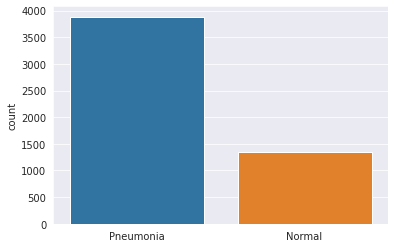

In [34]:
graph=[]
for i in train1:
    if(i[1] == 0):
        graph.append("Pneumonia")
    else:
        graph.append("Normal")
sns.set_style('darkgrid')
sns.countplot(graph)

#### This is the extra dataset we'll use later look it's closer to the Pneumonia

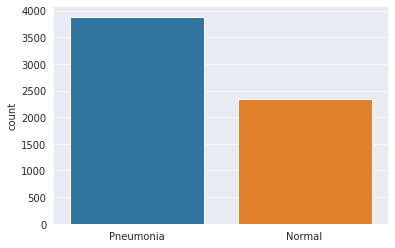

In [20]:
graph=[]
for i in train:
    if(i[1] == 0):
        graph.append("Pneumonia")
    else:
        graph.append("Normal")
sns.set_style('darkgrid')
sns.countplot(graph)

We see in the chart above that there is a class imbalance, the Pneumonia class has significantly more x-rays than the Normal class

What do our x-Rays look like? Can we see a difference between normal and pneumonia x-rays?

Text(0.5, 1.0, 'NORMAL')

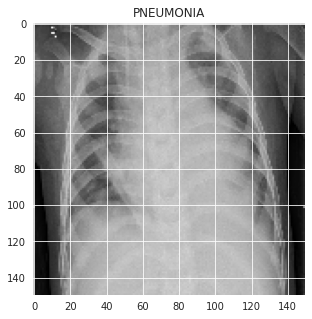

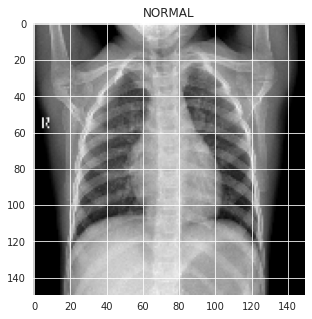

In [21]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

# BASELINE DATA SET WITH OUT AUGMENTATION

We see from the x-rays above that we can actually see the difference between the two types of lungs. In the Pneumonia x-ray there is a higher opacity where there is fluid

Now we start preparing the data to be modeled

In [39]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train1:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [40]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [41]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

Training the Model

In [42]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 19, 64)       

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(x_train,y_train, batch_size=32,epochs = 12 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])

Train on 5231 samples, validate on 16 samples
Epoch 1/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.3616 - accuracy: 0.8371 - val_loss: 0.3710 - val_accuracy: 0.8750
Epoch 2/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.1411 - accuracy: 0.9453 - val_loss: 0.9731 - val_accuracy: 0.8125
Epoch 3/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.1083 - accuracy: 0.9612 - val_loss: 0.8663 - val_accuracy: 0.8125

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.0555 - accuracy: 0.9803 - val_loss: 0.3445 - val_accuracy: 0.9375
Epoch 5/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.0447 - accuracy: 0.9826 - val_loss: 0.4854 - val_accuracy: 0.9375
Epoch 6/12
5231/5231 [==============================] - 6s 1ms/step - loss: 0.0376 - accuracy: 0.9853 - val_loss: 0.2525 - val_accuracy: 0.9375

Epoch 00

In [44]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 422us/step
Loss of the model is -  1.7522562131693913
624/624 [==============================] - 0s 382us/step
Accuracy of the model is -  74.83974099159241 %


We see from our data augmented baseline model that we acheived an Accuracy of 72.11% However we know that Accuracy doesn't tell us the whole story, so lets dive deeper.

Post Model Analysis

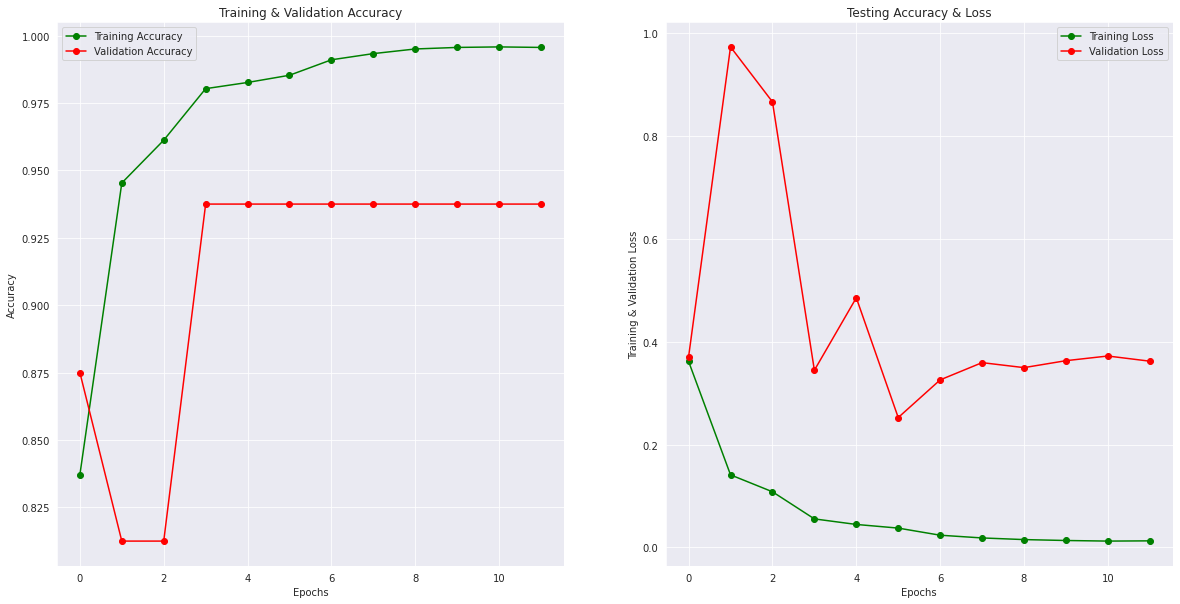

In [45]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [46]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [47]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.71      1.00      0.83       390
   Normal (Class 1)       1.00      0.33      0.50       234

           accuracy                           0.75       624
          macro avg       0.86      0.66      0.66       624
       weighted avg       0.82      0.75      0.71       624



In [48]:
cm= confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [157,  77]])

In [49]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

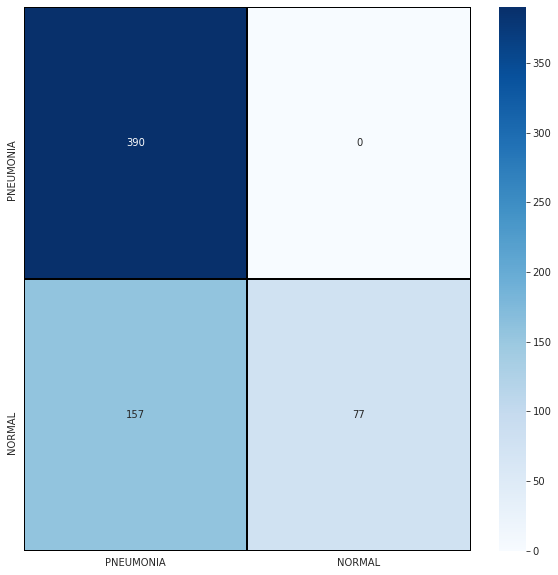

In [50]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

# Modeling with Data Augmentation to combat imbalance

In [56]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train1:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [57]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [58]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [59]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [60]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size=32),epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 11s 65ms/step - loss: 1.2378 - accuracy: 0.8128 - val_loss: 2.5313 - val_accuracy: 0.6250
Epoch 2/12
164/164 [==============================] - 11s 66ms/step - loss: 0.8704 - accuracy: 0.8337 - val_loss: 1.8264 - val_accuracy: 0.5625
Epoch 3/12
164/164 [==============================] - 11s 66ms/step - loss: 0.5780 - accuracy: 0.8457 - val_loss: 1.7617 - val_accuracy: 0.5625

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 4/12
164/164 [==============================] - 11s 65ms/step - loss: 0.5217 - accuracy: 0.8471 - val_loss: 0.8747 - val_accuracy: 0.6250
Epoch 5/12
164/164 [==============================] - 11s 65ms/step - loss: 0.4380 - accuracy: 0.8650 - val_loss: 0.9816 - val_accuracy: 0.6875
Epoch 6/12
164/164 [==============================] - 11s 65ms/step - loss: 0.4434 - accuracy: 0.8438 - val_loss: 1.3909 - val_accuracy: 0.6875
Epoch 7/12
164/164 [==============================] - 11s 64ms/step - l

In [62]:
model.save('/content/drive/My Drive/chest_xray/data_augmentation_model')

In [63]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 422us/step
Loss of the model is -  0.6230382457948648
624/624 [==============================] - 0s 408us/step
Accuracy of the model is -  83.65384340286255 %


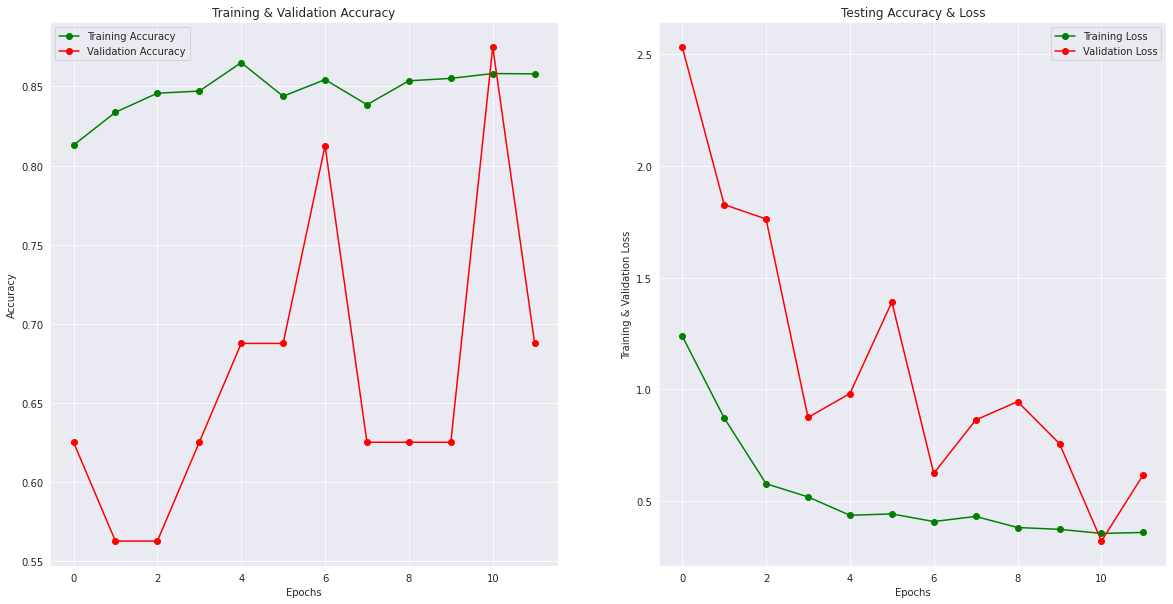

In [64]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [65]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.81      0.97      0.88       390
   Normal (Class 1)       0.93      0.61      0.74       234

           accuracy                           0.84       624
          macro avg       0.87      0.79      0.81       624
       weighted avg       0.85      0.84      0.83       624



In [66]:
cm= confusion_matrix(y_test,predictions)
cm

array([[379,  11],
       [ 91, 143]])

In [67]:
# Addittion of new data!

In [68]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [69]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(x_train,y_train, batch_size=32,epochs = 12 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])

Train on 6226 samples, validate on 16 samples
Epoch 1/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.2881 - accuracy: 0.8987 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 2/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.2564 - accuracy: 0.9081 - val_loss: 0.1535 - val_accuracy: 0.9375
Epoch 3/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.2311 - accuracy: 0.9160 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 4/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.2095 - accuracy: 0.9229 - val_loss: 0.1524 - val_accuracy: 0.9375
Epoch 5/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.1917 - accuracy: 0.9306 - val_loss: 0.1512 - val_accuracy: 0.9375
Epoch 6/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.1789 - accuracy: 0.9377 - val_loss: 0.1500 - val_accuracy: 0.9375
Epoch 7/12
6226/6226 [==============================] - 7s 1ms/step - loss: 0.1662 - accur

In [70]:
model.save('/content/drive/My Drive/chest_xray/new_data_model')

In [71]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 429us/step
Loss of the model is -  0.6011949709783762
624/624 [==============================] - 0s 398us/step
Accuracy of the model is -  81.57051205635071 %


In [72]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [87]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
cm= confusion_matrix(y_test,predictions)

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.77      0.99      0.87       390
   Normal (Class 1)       0.98      0.52      0.68       234

           accuracy                           0.82       624
          macro avg       0.88      0.76      0.77       624
       weighted avg       0.85      0.82      0.80       624



In [88]:
cm

array([[388,   2],
       [113, 121]])

In [164]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [165]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [143]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))


model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(MaxPool2D((2,2), strides=2, padding='same')

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_69 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
dropout_70 (Dropout)         (None, 37, 37, 64)      

In [166]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_91 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 18, 18, 64)      

In [168]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size=100),epochs = 12 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/12
63/63 [==============================] - 12s 192ms/step - loss: 0.4501 - accuracy: 0.7878 - val_loss: 0.8157 - val_accuracy: 0.5000
Epoch 2/12
63/63 [==============================] - 12s 187ms/step - loss: 0.3381 - accuracy: 0.8538 - val_loss: 0.9447 - val_accuracy: 0.5625
Epoch 3/12
63/63 [==============================] - 12s 189ms/step - loss: 0.2861 - accuracy: 0.8840 - val_loss: 0.5854 - val_accuracy: 0.6875
Epoch 4/12
63/63 [==============================] - 12s 187ms/step - loss: 0.2359 - accuracy: 0.9078 - val_loss: 1.2629 - val_accuracy: 0.5625
Epoch 5/12
63/63 [==============================] - 12s 189ms/step - loss: 0.2189 - accuracy: 0.9128 - val_loss: 1.4505 - val_accuracy: 0.6250
Epoch 6/12
63/63 [==============================] - 12s 186ms/step - loss: 0.2009 - accuracy: 0.9232 - val_loss: 1.1880 - val_accuracy: 0.5625
Epoch 7/12
63/63 [==============================] - 12s 185ms/step - loss: 0.1743 - accuracy: 0.9337 - val_loss: 1.4378 - val_accuracy: 0.5000

In [169]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 476us/step
Loss of the model is -  0.36544586144960844
624/624 [==============================] - 0s 442us/step
Accuracy of the model is -  92.14743375778198 %


In [170]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [171]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
cm= confusion_matrix(y_test,predictions)

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.93      0.85      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [173]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

### Visualizing our Convolution Layers

Let's see how our CNN model is breaking up the features! 

In [176]:
from keras.preprocessing import image
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


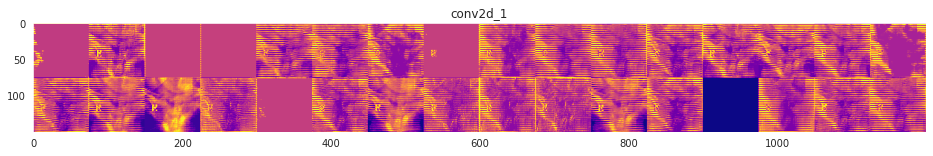

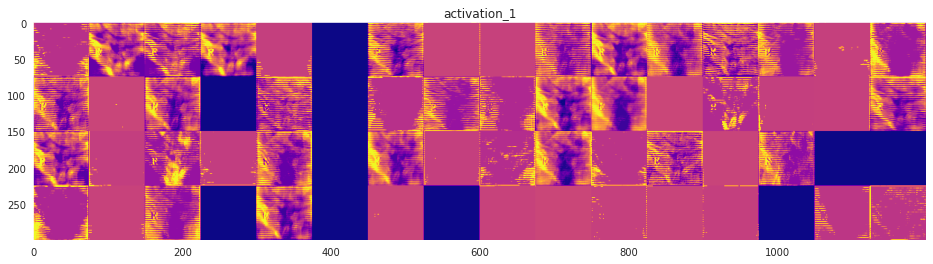

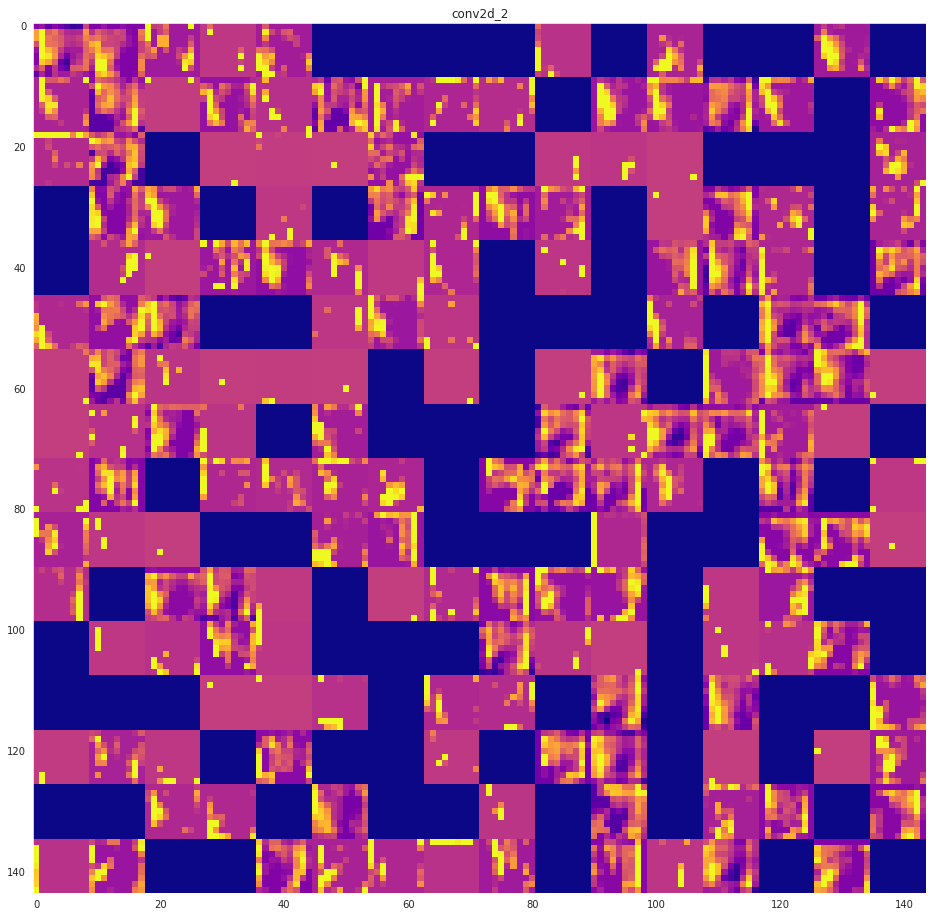

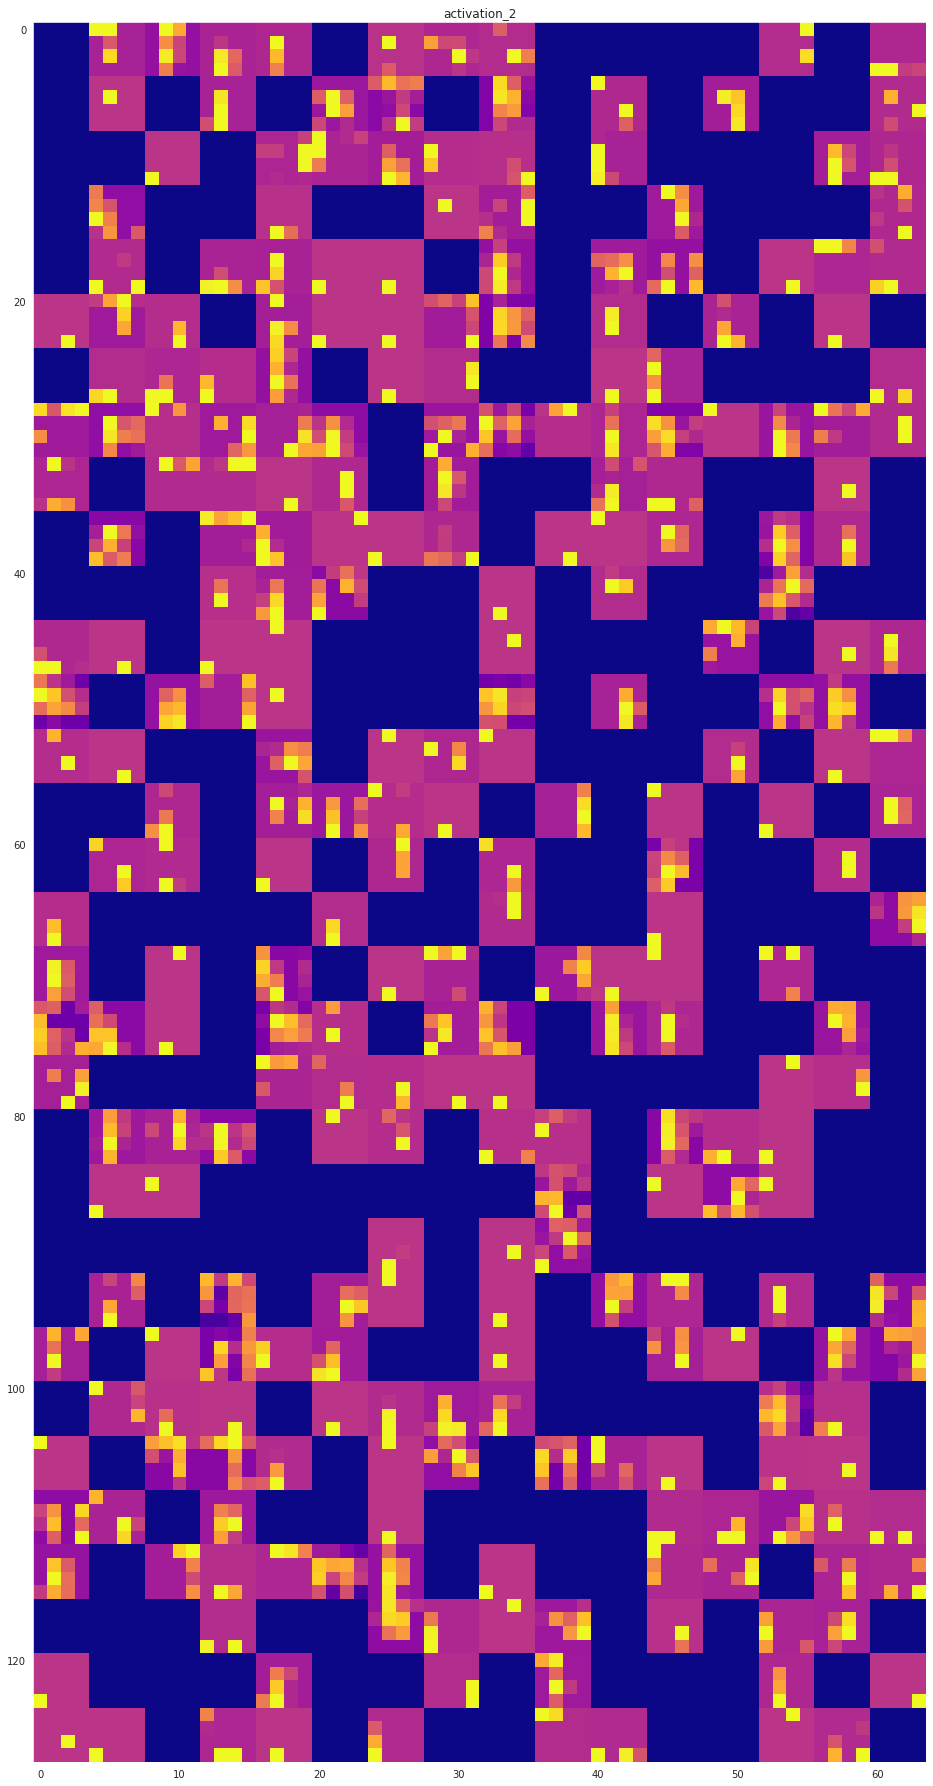

In [189]:
layer_outputs = [layer.output for layer in model.layers[:50]]
test_image = '/content/drive/My Drive/chest_xray/test_image.jpeg'

img = image.load_img(test_image, target_size=(img_size, img_size))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor.reshape(-1, img_size, img_size, 1)
# img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

layer_names = ['conv2d_1', 'activation_1', 'conv2d_2', 'activation_2', 'conv2d_5', 'activation_5']
activ_list = [activations[1], activations[3], activations[11], activations[13]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')

In [55]:
#Show what our model predicted in pictures